# Daily Forecast Model with Dual Seasonality

In current version, there is no implicit dual seasonal model yet.  To model dual seasonality, we can leverage `fourier series` to model the second seasonality which has longer duration. Also note that here, we are going to demonstrate a `multiplicative` model.  Hence, we will leverage `log` transformation explicitly.

In [10]:
import pandas as pd
import numpy as np
import math
import sys
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from orbit.dlt import DLT
from orbit.dlt import LGT
from orbit.utils.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.simulation import make_trend, make_seasonality
from orbit.utils.utils import fourier_series_df

## Case I

First, we test on synthetic data as generated as `y(t) = exp(u(t) + s1(t) + s2(t) + noise)`

In [11]:
date_col='ds'
response_col='y'

series_len = 356 * 5
seed = 2020
u = make_trend(series_len=series_len, rw_loc=1e-3, rw_scale=1e-3, type='rw', seed=seed)
s1 =  make_seasonality(series_len=series_len, seasonality=365.25, order=3, scale=1e-1, type='fourier', seed=seed)
s2 =  make_seasonality(series_len=series_len, seasonality=7, duration=1, scale=1e-1, type='discrete', seed=seed)
noise = np.random.default_rng(seed).normal(0, 1e-1, series_len)
obs = np.exp(u + s1 + s2 + noise) * 1000
dt = pd.date_range(start='2010-01-01', periods=series_len, freq="1D")
raw_df=pd.DataFrame({'ds':dt, 'y':obs})

In [12]:
raw_df.head(5)

,ds,y
0,2010-01-01,1151.973677
1,2010-01-02,942.433667
2,2010-01-03,1185.866718
3,2010-01-04,687.702217
4,2010-01-05,870.437595


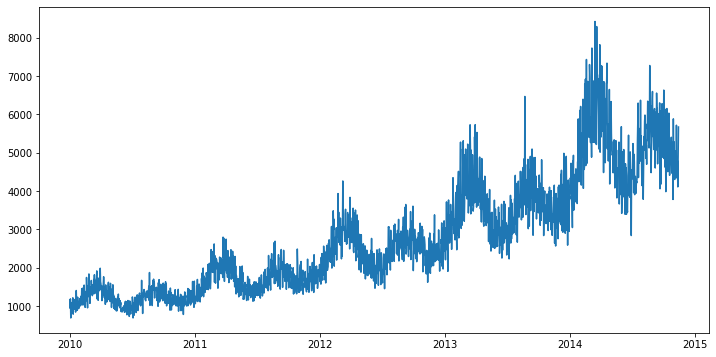

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(raw_df[date_col], raw_df[response_col])

In [14]:
df, fs_cols = fourier_series_df(raw_df, date_col, 365.25, 3)

In [15]:
df['log_y'] = np.log(df[response_col])

In [16]:
df.head(3)

,ds,y,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3,log_y
0,2010-01-01,1151.973677,-9.797174e-15,1.000000,-1.959435e-14,1.000000,2.745190e-14,1.000000,7.049232
1,2010-01-02,942.433667,1.720158e-02,0.999852,3.439806e-02,0.999408,5.158437e-02,0.998669,6.848466
2,2010-01-03,1185.866718,3.439806e-02,0.999408,6.875541e-02,0.997634,1.030314e-01,0.994678,7.078229


In [17]:
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

We set the `fourier series` as regressors. Note that with version newer than `0.6.3`, we introduce a parameter `period` for `DLT` to control `time_delta` attribute of the model in order to calculate step size behind the model.

In [18]:
mcmc_mod = DLT(
    response_col='log_y',
    date_col=date_col,
    infer_method='mcmc',
    predict_method='full',
    num_warmup=4000, 
    num_sample=500,
    inference_engine='stan',
    seasonality=7,
    regressor_col=fs_cols,
    is_multiplicative=False,
    seed=2020,
    regressor_sigma_prior=[10.0] * len(fs_cols),
    period=365.25,
)

In [19]:
%%time
mcmc_mod.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 777 ms, sys: 789 ms, total: 1.57 s
Wall time: 2min 17s


In [20]:
predicted_df = mcmc_mod.predict(df=test_df)

We reverse back to real scale to test performance.

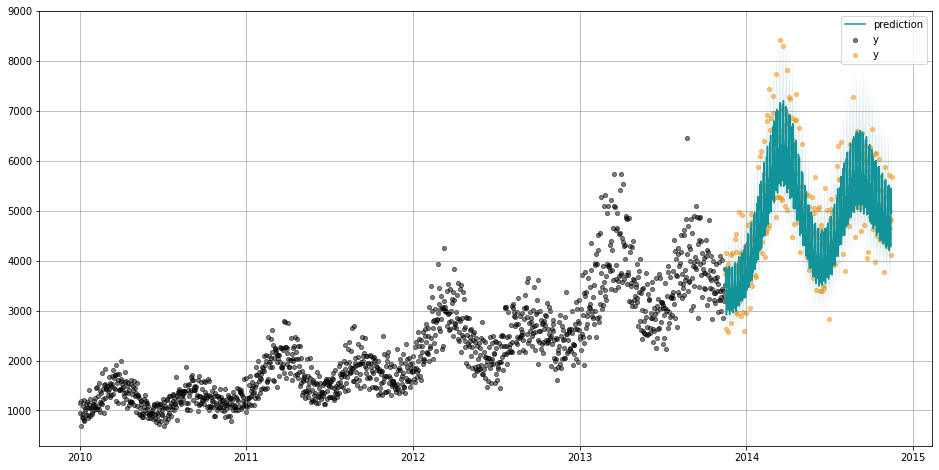

In [21]:
predicted_df[[5, 50, 95]] = predicted_df[[5, 50, 95]].apply(np.exp)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=mcmc_mod.date_col, actual_col=response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Case II - Melbourne, Australia Daily Temperature

We test a popular [dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv) describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
See https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne
for details.

In [22]:
DATA_FILE = "./data/melbourne-daily-min-temperatures.csv"
raw_df = pd.read_csv(DATA_FILE, parse_dates=['Date'])
date_col='Date'
response_col='Temp'

In [23]:
raw_df.head(5)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


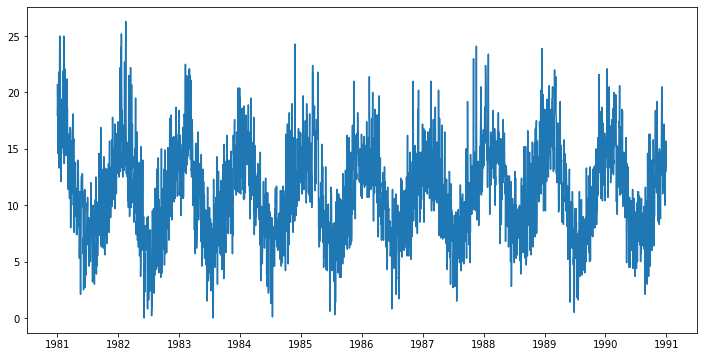

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(raw_df[date_col], raw_df[response_col])

A few things need to be noticed here:
1. The series show a significant smoothness in the level where stochastic trend existence is questionable
2. The series show a signficant sine/cosine wave pattern

Since our model assumes a stochastic trend, it imposes a challenge in the current existed settings as it implies large degeneracy during optimization process.  One way to overcome such challenge is to impose strong prior of `lev_sm` and `slp_sm` with small value.

In [25]:
df, fs_cols = fourier_series_df(raw_df, date_col, 365.25, 10)
df['log_y'] = np.log1p(df[response_col])
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

In [30]:
mcmc_mod = DLT(
    response_col='log_y',
    date_col=date_col,
    infer_method='map',
    predict_method='map',
#     num_warmup=4000, 
#     num_sample=500,
    inference_engine='stan',
    seasonality=7,
    regressor_col=fs_cols,
    is_multiplicative=False,
    seed=2020,
    regressor_sigma_prior=[10.0] * len(fs_cols),
    period=365.25,
    level_sm_input=0.0001,
)

Starting version `0.6.3`, priors in smoothing params are modeled as beta distribution by two parameters with suffix `_loc` (mode) and `_shape` (concentration). A simple code to show how these two parameters work.

In [32]:
# super tight prior by putting large shape value
# mcmc_mod.level_smoothing_shape = 1e4
# mcmc_mod.slope_smoothing_shape = 1e4
# mcmc_mod.level_smoothing_loc = 1e-4
# mcmc_mod.slope_smoothing_loc = 1e-4

In [33]:
%%time
mcmc_mod.fit(df=train_df)

CPU times: user 2.34 s, sys: 77.6 ms, total: 2.41 s
Wall time: 2.47 s


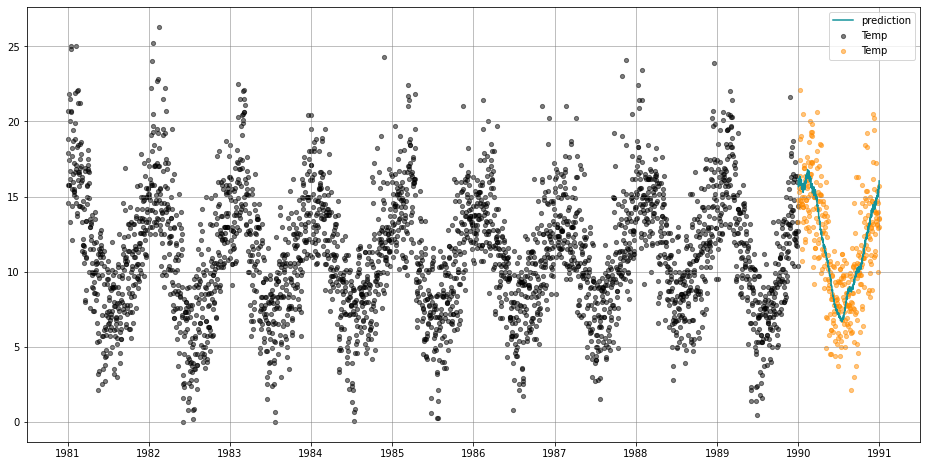

In [36]:
predicted_df = mcmc_mod.predict(df=test_df)
# predicted_df[[5, 50, 95]] = predicted_df[[5, 50, 95]].apply(np.exp)
predicted_df[['prediction']] = predicted_df[['prediction']].apply(np.exp)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=mcmc_mod.date_col, actual_col=response_col, 
                    pred_col='prediction',
#                     pred_col=50, 
#                     pred_quantiles_col=[5,95],
                    test_actual_df=test_df)